This notebook is an attempt at trying to get the broadband directivity functions as Lasse suggested. 
In Madsen & Wahlberg 2007 (Deep Sea Research), the authors describe the integration of the directivity function over the signal's frequency range as a way to get the broadband directivity function. Let's try it out here. 

2021-05-21

In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import sympy 
from sympy import Integral, symbols, pi, lambdify
import beamshapes 
from beamshapes import piston_in_infinite_baffle as pib
from beamshapes.utilities import dB
import tqdm

In [2]:
%matplotlib notebook

In [3]:
a,k,theta,kmin,kmax = symbols('a k theta kmin kmax')

This is the famous piston in an infinite baffle directivity function. 

In [4]:
pib.d_theta

2*besselj(1, a*k*sin(theta))/(a*k*sin(theta))

Let's now integrate it wrt to the k from kmin-->kmax

In [5]:
Integral(pib.d_theta, (k,kmin,kmax))

Integral(2*besselj(1, a*k*sin(theta))/(a*k*sin(theta)), (k, kmin, kmax))

In [6]:
# make SymPy solve the integral 
integral_solution = Integral(pib.d_theta, (k,kmin,kmax)).doit()
integral_solution

kmax*sqrt(sin(theta)**2)*hyper((1/2,), (3/2, 2), -a**2*kmax**2*sin(theta)**2/4)/sin(theta) - kmin*sqrt(sin(theta)**2)*hyper((1/2,), (3/2, 2), -a**2*kmin**2*sin(theta)**2/4)/sin(theta)

So, it looks like SymPy could solve this integral - which is nice! Let's convert the expression into a function and get some outputs for broadband beamshapes!

In [7]:
broadband_directivity = lambdify([kmin,kmax,a,theta,], integral_solution, 'sympy')

In [8]:
broadband_directivity(100,200,0.1,0.001)

200.0*hyper((0.5,), (1.5, 2), -9.99999666666711e-5) - 100.0*hyper((0.5,), (1.5, 2), -2.49999916666678e-5)

In [29]:
thetas = np.linspace(-np.pi/2, np.pi/2,50)
kmin_v, kmax_v = 50,250
av = 0.01
bbd_dtheta = np.array(np.abs([broadband_directivity(kmin_v, kmax_v, av, each).evalf()  for each in thetas]), 'float32')
db_dtheta = dB(bbd_dtheta)
db_dtheta -= np.max(db_dtheta) # normalise to on-axis

<IPython.core.display.Javascript object>


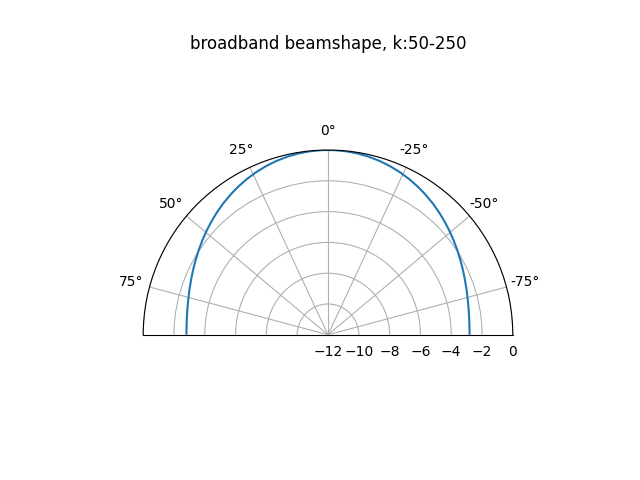

Text(0.5, 1.0, 'broadband beamshape, k:50-250')

In [30]:
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(thetas, db_dtheta)
a0.set_theta_zero_location("N");a0.set_thetamax(90);a0.set_thetamin(-90);plt.yticks(np.arange(-12,2,2));
plt.title(f'broadband beamshape, k:{kmin_v}-{kmax_v}')

Let's compare this to the beamshapes at between $k=50-250$

In [31]:
onefreq_dthetas = []
kvalues = np.arange(50,300,50)
for kv in tqdm.tqdm(kvalues):
    _, dtheta_onefreq = pib.piston_in_infinite_baffle_directivity(thetas, {'k':kv, 'a':av})
    onefreq_dthetas.append(dtheta_onefreq)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.58s/it]


<IPython.core.display.Javascript object>


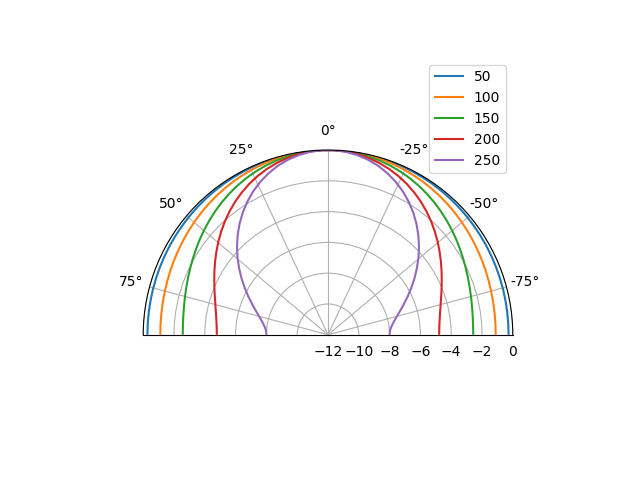

In [35]:
plt.figure()
a1 = plt.subplot(111, projection='polar')
for each, kv in zip(onefreq_dthetas,kvalues):
    a1.plot(thetas, each,label=str(kv))
a1.set_theta_zero_location("N");a1.set_thetamax(90);a1.set_thetamin(-90);plt.yticks(np.arange(-12,2,2));
plt.legend();

### Extending this exercise to other models...To be done. 